# Imports

In [1]:
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import spikeA
from spikeA.Spike_train import Spike_train
from spikeA.Animal_pose import Animal_pose
from spikeA.Spatial_properties import Spatial_properties
from spikeA.Neuron import Simulated_place_cell, Simulated_grid_cell
from scipy.stats import multivariate_normal
from scipy.stats import poisson
from scipy.interpolate import interp1d
from tqdm import tqdm
from scipy import stats
from scipy.ndimage import gaussian_filter1d

%run ../../setup_project.py
%run ../../generic_plot_functions.py
%run functions.py

In [2]:
projectName, dataPath, dlcModelPath, myProject, sSessions = setup_project_session_lists(projectName="autopi_mec",dataPath=PROJECT_DATA_PATH,dlcModelPath="")

creating myProject, an autopipy.project object
Project name: autopi_mec
dataPath: /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt/
dlcModelPath: 
Reading /ext_drives/d91/data/projects/jingjie/Peng_et.al_2025_noInt//sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


# Params

In [3]:
boxprops = {'edgecolor': 'k', 'linewidth': 1.5}
lineprops = {'color': 'k', 'linewidth': 1.5}

boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                   'whiskerprops': lineprops, 'capprops': lineprops,
                   'width': 0.75})
stripplot_kwargs = dict({'linewidth': 1, 'size': 3.5, 'alpha': 0.8},)

OBSERVATIONCOLOR = ["#00afb9",'#f07167']

In [4]:
fn = myProject.dataPath+"/results/sessionList_pathReconstruction.csv"
print("Loading",fn)
sessionNameList = list(pd.read_csv(fn)["session"])
sessionNameList

Loading /ext_drives/d91/data/projects/jingjie/dyrad_data_files/results/sessionList_pathReconstruction.csv


['jp486-19032023-0108',
 'jp486-18032023-0108',
 'jp3269-28112022-0108',
 'jp486-16032023-0108',
 'jp452-25112022-0110',
 'jp486-24032023-0108',
 'jp486-22032023-0108',
 'jp452-24112022-0109',
 'jp486-15032023-0108',
 'jp3120-25052022-0107',
 'jp3120-26052022-0107',
 'jp451-28102022-0108',
 'jp486-20032023-0108',
 'jp486-06032023-0108',
 'jp486-26032023-0108',
 'jp486-17032023-0108',
 'jp451-29102022-0108',
 'jp3269-30112022-0110',
 'mn8578-23122021-0108',
 'jp451-30102022-0108',
 'jp3269-27112022-0108',
 'jp486-10032023-0108',
 'jp486-05032023-0108',
 'jp3269-29112022-0108',
 'mn8578-15122021-0107',
 'jp486-13032023-0108',
 'mn8578-17122021-0107',
 'jp3120-24052022-0108',
 'jp452-23112022-0108',
 'jp1686-29042022-0109',
 'jp1687-26052022-0107',
 'jp1686-26042022-0108',
 'jp451-27102022-0108',
 'jp451-01112022-0108',
 'jp1686-28042022-0107',
 'jp3269-26112022-0108',
 'mn8578-25122021-0107',
 'mn8578-05122021-0108',
 'jp486-02032023-0108',
 'mn8578-10122021-0107',
 'jp3129-05062022-0108

In [5]:
# Get a dictionary of all the sessionList:

def get_grid_param_transformation(sSes):
    """
    Get the dictionary used to go from v0,v1,v2 to x,y
    """
    fn = sSes.fileBase+".grid_cell_parameters.pkl"
    #print("Loading:",fn)
    with open(fn, 'rb') as fp: 
        params = pickle.load(fp)
    oriFlexible = np.stack([p["grid_param_model_flexible"]["orientation"] for p in params])
    periodFlexible = np.stack([p["grid_param_model_flexible"]["period"] for p in params])
    grid_param_transformation = {
        "period": np.median(periodFlexible,axis=0),
        "orientation": np.median(oriFlexible,axis=0),
    }
    return grid_param_transformation


gridParamsDictionary = {}
for session in sessionNameList:

    sSes = [ s for s in sSessions if s.name == session][0]
    
    print(get_grid_param_transformation(sSes))
    
    gridParamsDictionary[session] = get_grid_param_transformation(sSes)

{'period': array([37.46781 , 34.528538, 33.810795], dtype=float32), 'orientation': array([0.80596393, 1.9258461 , 2.8699589 ], dtype=float32)}
{'period': array([37.031937, 34.524117, 33.687164], dtype=float32), 'orientation': array([0.8427626, 1.9657676, 2.9200864], dtype=float32)}
{'period': array([31.933495, 30.097876, 30.250917], dtype=float32), 'orientation': array([0.28789577, 1.3372808 , 2.334365  ], dtype=float32)}
{'period': array([39.864037, 35.82746 , 33.8515  ], dtype=float32), 'orientation': array([0.7910558, 1.9216716, 2.8689423], dtype=float32)}
{'period': array([36.095802, 36.521828, 34.609344], dtype=float32), 'orientation': array([0.59335333, 1.6718721 , 2.7300894 ], dtype=float32)}
{'period': array([42.643997, 42.326103, 40.69154 ], dtype=float32), 'orientation': array([0.8294167, 1.9119685, 2.9168406], dtype=float32)}
{'period': array([39.310097, 38.667435, 37.443188], dtype=float32), 'orientation': array([0.8762901, 1.9995005, 2.9955864], dtype=float32)}
{'period': 

In [6]:
gridParamsDictionary

{'jp486-19032023-0108': {'period': array([37.46781 , 34.528538, 33.810795], dtype=float32),
  'orientation': array([0.80596393, 1.9258461 , 2.8699589 ], dtype=float32)},
 'jp486-18032023-0108': {'period': array([37.031937, 34.524117, 33.687164], dtype=float32),
  'orientation': array([0.8427626, 1.9657676, 2.9200864], dtype=float32)},
 'jp3269-28112022-0108': {'period': array([31.933495, 30.097876, 30.250917], dtype=float32),
  'orientation': array([0.28789577, 1.3372808 , 2.334365  ], dtype=float32)},
 'jp486-16032023-0108': {'period': array([39.864037, 35.82746 , 33.8515  ], dtype=float32),
  'orientation': array([0.7910558, 1.9216716, 2.8689423], dtype=float32)},
 'jp452-25112022-0110': {'period': array([36.095802, 36.521828, 34.609344], dtype=float32),
  'orientation': array([0.59335333, 1.6718721 , 2.7300894 ], dtype=float32)},
 'jp486-24032023-0108': {'period': array([42.643997, 42.326103, 40.69154 ], dtype=float32),
  'orientation': array([0.8294167, 1.9119685, 2.9168406], dtype

# Data

In [7]:
fn = myProject.dataPath+"/results/reconstuctionDFOF.csv"
print("Loading", fn)
dfOF = pd.read_csv(fn)

Loading /ext_drives/d91/data/projects/jingjie/dyrad_data_files/results/reconstuctionDFOF.csv


In [8]:
fn = myProject.dataPath+"/results/reconstuctionDFAutoPI.csv"
print("Loading",fn)
dfAutoPI = pd.read_csv(fn)

Loading /ext_drives/d91/data/projects/jingjie/dyrad_data_files/results/reconstuctionDFAutoPI.csv


# Test rotation

In [9]:
def calculate_circular_mean(values):
    # Convert to numpy array for efficiency
    angles = values

    # Calculate mean of sine and cosine components
    mean_sin = np.nanmean(np.sin(angles))
    mean_cos = np.nanmean(np.cos(angles))

    # Compute the circular mean using arctangent
    mean_angle = np.arctan2(mean_sin, mean_cos)

    # Adjust the angle to be within -pi to pi if necessary
    if mean_angle > np.pi:
        mean_angle -= 2 * np.pi
    elif mean_angle < -np.pi:
        mean_angle += 2 * np.pi
        
    return mean_angle

def mean_mvt_direction_error(mvtDirError):
    """
    Calculate the mean direction of the mvt direction error
    """
    xMean = np.nanmean(np.cos(mvtDirError))
    yMean = np.nanmean(np.sin(mvtDirError)) 
    return np.arctan2(yMean, xMean)

def meanMvtDirError_wrapper(df):
    return  mean_mvt_direction_error(df.mvtDirError)

In [10]:
dfMerged = pd.concat([dfOF,dfAutoPI])

# Find rotation association between light and dark trials compared to OF

In [11]:
gridRotationDf_corrected = dfMerged[dfMerged.condition.isin(['all_light','all_dark'])].groupby(["session","condition","light",'trialNo']).apply(meanMvtDirError_wrapper).reset_index()
gridRotationDf_corrected.columns = ["session","condition","light",'trialNo',"rotation"]
gridRotationDf_corrected

,session,condition,light,trialNo,rotation
0,jp1084-05042022-0107,all_dark,dark,8.0,0.721286
1,jp1084-05042022-0107,all_dark,dark,10.0,-0.371360
2,jp1084-05042022-0107,all_dark,dark,12.0,0.699767
3,jp1084-05042022-0107,all_dark,dark,14.0,-0.215179
4,jp1084-05042022-0107,all_dark,dark,16.0,-1.266864
...,...,...,...,...,...
5852,mn8599-11022022-0107,all_light,light,123.0,-1.714297
5853,mn8599-11022022-0107,all_light,light,125.0,-1.437161
5854,mn8599-11022022-0107,all_light,light,127.0,1.049259
5855,mn8599-11022022-0107,all_light,light,129.0,0.121754


In [12]:
# fn = myProject.dataPath+"/results/gridRotationDf_trial_rotation.csv"
# print("Saving", fn)
# gridRotationDf_corrected.to_csv(fn,index=False)

In [13]:
gridRotationDf_corrected['abs_rotation'] = np.abs(gridRotationDf_corrected['rotation'])

In [14]:
all_dark_trial_df = gridRotationDf_corrected[gridRotationDf_corrected.session.isin(useAble)&(gridRotationDf_corrected.condition == 'all_dark')].copy()

In [15]:
len(all_dark_trial_df.session.unique())

24

In [16]:
# fn = myProject.dataPath+"/results/rotation_per_trial_after_correction.csv"
# all_dark_trial_df.to_csv(fn)

# Recalculate anchoring strength

In [17]:
def calculate_bridge_toroidal_position_trial_rotation(gridRotationDf_corrected,saveToFile=False,save_suffix='_trial_rotation'):
    dfBridgeAnchoring = pd.DataFrame()
    nTrialBins=3
    maxPathTime = 3
    bridgePose= np.array([[0,-50]]) # where the bridge is
    conditions = ['searchToLeverPath_light','searchToLeverPath_dark','atLever_light','atLever_dark', 'homingFromLeavingLeverToPeriphery_light', 'homingFromLeavingLeverToPeriphery_dark']
    
    for sessionName in tqdm(sessionNameList):
        for condition in conditions:
            df = dfAutoPI[(dfAutoPI.session == sessionName) & (dfAutoPI.condition == condition)]    
            light= condition.split("_")[1]
            
            # get an object to transform the data from x,y coordinate to toroidal coordinates
            sSes = [ s for s in sSessions if s.name == sessionName][0]
            grid_param_transformation = get_grid_param_transformation(sSes)
            gridRotationDf = get_grid_rotation_df(myProject)
            gridRotationDf = gridRotationDf[gridRotationDf.condition.isin(["all_light","all_dark"])]
            rot = gridRotationDf.rotation[(gridRotationDf.session==sessionName)&(gridRotationDf.light==light)].item()
            
            
            # loop for trials
            for trialNo in df["trialNo"].unique():
                
                rDf = gridRotationDf_corrected[(gridRotationDf_corrected.session == sessionName)&(gridRotationDf_corrected.trialNo == trialNo)&(gridRotationDf_corrected.light == light)]

                if rDf.empty:
                    print(sessionName,trialNo)
                    continue
                
                rotationThisTrial = rDf.rotation.values[0]
                
                gt = gridTransformation(period = grid_param_transformation["period"],
                       orientation = grid_param_transformation["orientation"]-rot-rotationThisTrial) # correct for th rotation #-rot-rotationThisTrial
            
            
                dfTrial = df[df.trialNo==trialNo]
                withinPathTimeMax = dfTrial.withinPathTime.max()
                if withinPathTimeMax > maxPathTime:
                    withinPathTimeMax = maxPathTime
                
                binSize = withinPathTimeMax/nTrialBins
                for trialBin in range(nTrialBins):

                    dfTrialBin = dfTrial[dfTrial.withinPathTime.between(trialBin*binSize,(trialBin+1)*binSize)]

                    if len(dfTrialBin.withinPathTime) > 0:
                        mousePose = np.stack([dfTrialBin.xPose,dfTrialBin.yPose]).T # mouse position
                        vectorBridge = bridgePose-mousePose # vector from mouse to lever
                        gs_vector = gt.poseToGridSpace(vectorBridge,returnCosSin=False) # vector on the torus

                        # add the vector to the active location on the torus
                        v0Bridge = dfTrialBin.v0 + gs_vector[:,0]
                        v1Bridge = dfTrialBin.v1 + gs_vector[:,1]

                        # make sure that v0,v1 coordinates range from -np to np
                        v0Bridge = np.arctan2(np.sin(v0Bridge),np.cos(v0Bridge))
                        v1Bridge = np.arctan2(np.sin(v1Bridge),np.cos(v1Bridge))

                        dfTrialBin["v0Bridge"] = v0Bridge
                        dfTrialBin["v1Bridge"] = v1Bridge
                        dfTrialBin["trialBin"] = trialBin

                        dfBridgeAnchoring = pd.concat([dfBridgeAnchoring,dfTrialBin])
    
    # save the calculation
    if saveToFile:
        fn = myProject.dataPath+f"/results/dfBridgeAnchoring{save_suffix}.csv"
        print("Saving",fn)
        dfBridgeAnchoring.to_csv(fn, index=False)
    
    return dfBridgeAnchoring

def calculate_lever_toroidal_position_trial_rotation(gridRotationDf_corrected,saveToFile=False):
    dfLeverAnchoring = pd.DataFrame()
    nTrialBins=3
    maxPathTime = 3
    conditions = ['searchToLeverPath_light','searchToLeverPath_dark','atLever_light','atLever_dark', 'homingFromLeavingLeverToPeriphery_light', 'homingFromLeavingLeverToPeriphery_dark']
    
    for sessionName in tqdm(sessionNameList):
        fn = myProject.sessionPathFromSessionName(sessionName)+"/ses.pickle"
        with open(fn, 'rb') as handle:
            ses = pickle.load(handle)

        for condition in conditions:
            df = dfAutoPI[(dfAutoPI.session == sessionName) & (dfAutoPI.condition == condition)]    
            light= condition.split("_")[1]
            
            # get an object to transform the data from x,y coordinate to toroidal coordinates
            sSes = [ s for s in sSessions if s.name == sessionName][0]
            grid_param_transformation = get_grid_param_transformation(sSes)
            gridRotationDf = get_grid_rotation_df(myProject)
            gridRotationDf = gridRotationDf[gridRotationDf.condition.isin(["all_light","all_dark"])]
            rot = gridRotationDf.rotation[(gridRotationDf.session==sessionName)&(gridRotationDf.light==light)].item()
            
            
            # loop for trials
            for trialNo in df["trialNo"].unique():
                                
                rDf = gridRotationDf_corrected[(gridRotationDf_corrected.session == sessionName)&(gridRotationDf_corrected.trialNo == trialNo)&(gridRotationDf_corrected.light == light)]

                if rDf.empty:
                    print(sessionName,trialNo)
                    continue
                
                rotationThisTrial = rDf.rotation.values[0]
                
                
                gt = gridTransformation(period = grid_param_transformation["period"],
                       orientation = grid_param_transformation["orientation"]-rot-rotationThisTrial) # correct for th rotation #-rot-rotationThisTrial
            
            
                dfTrial = df[df.trialNo==trialNo]
                withinPathTimeMax = dfTrial.withinPathTime.max()
                if withinPathTimeMax > maxPathTime:
                    withinPathTimeMax = maxPathTime
                binSize = withinPathTimeMax/nTrialBins
                
                # position of the lever
                leverPose= ses.trialList[trialNo-1].lever.leverCenter # where the lever is
                
                for trialBin in range(nTrialBins):

                    dfTrialBin = dfTrial[dfTrial.withinPathTime.between(trialBin*binSize,(trialBin+1)*binSize)]

                    if len(dfTrialBin.withinPathTime) > 0:
                        mousePose = np.stack([dfTrialBin.xPose,dfTrialBin.yPose]).T # mouse position
                        vectorLever = leverPose-mousePose # vector from mouse to lever
                        gs_vector = gt.poseToGridSpace(vectorLever,returnCosSin=False) # vector on the torus

                        # add the vector to the active location on the torus
                        v0Lever = dfTrialBin.v0 + gs_vector[:,0]
                        v1Lever = dfTrialBin.v1 + gs_vector[:,1]

                        # make sure that v0,v1 coordinates range from -np to np
                        v0Lever = np.arctan2(np.sin(v0Lever),np.cos(v0Lever))
                        v1Lever = np.arctan2(np.sin(v1Lever),np.cos(v1Lever))

                        dfTrialBin["v0Lever"] = v0Lever
                        dfTrialBin["v1Lever"] = v1Lever
                        dfTrialBin["trialBin"] = trialBin

                        dfLeverAnchoring = pd.concat([dfLeverAnchoring,dfTrialBin])
    
    # save the calculation
    if saveToFile:
        fn = myProject.dataPath+f"/results/dfLeverAnchoring{save_suffix}.csv"
        print("Saving",fn)
        dfLeverAnchoring.to_csv(fn, index=False)
    
    return dfLeverAnchoring

In [18]:
len(gridRotationDf_corrected.session.unique())

49

In [19]:
dfAutoPI["v0"] = np.arctan2(dfAutoPI.v0_sin_smooth,dfAutoPI.v0_cos_smooth)
dfAutoPI["v1"] = np.arctan2(dfAutoPI.v1_sin_smooth,dfAutoPI.v1_cos_smooth)

In [21]:
# dfBridgeAnchoring = calculate_bridge_toroidal_position_trial_rotation(gridRotationDf_corrected = gridRotationDf_corrected)
# dfLeverAnchoring = calculate_lever_toroidal_position_trial_rotation(gridRotationDf_corrected = gridRotationDf_corrected)

In [ ]:
# len(dfLeverAnchoring.session.unique())

49

# Process the dataframes

In [22]:
def fit_bivariate_von_mises_to_toroidal_coordinate(df,col1="v0Bridge",col2="v1Bridge"):
    """
    fit a bivariate von Mises distribution to the bridge coordinates in the toroidal space
    """
    x0 = df[col1][np.isfinite(df[col1])]
    x1 = df[col2][np.isfinite(df[col2])]
    x = np.stack([x0,x1]).T
    resK,resM,resA = fit_bivariate_von_mises(x)
    return pd.DataFrame({"k0":[resK[0]],
                         "k1":[resK[1]],
                         "k":[resK.mean()],
                        "mu0":[resM[0]],
                        "mu1":[resM[0]]})

In [23]:
def process_anchoring_dataframes(dfBridgeAnchoring,dfLeverAnchoring):
    dfBridgeVonMises = dfBridgeAnchoring.groupby(["condition","session","trialBin"]).apply(fit_bivariate_von_mises_to_toroidal_coordinate,"v0Bridge","v1Bridge").reset_index()    
    dfLeverVonMises = dfLeverAnchoring.groupby(["condition","session","trialBin"]).apply(fit_bivariate_von_mises_to_toroidal_coordinate, "v0Lever", "v1Lever").reset_index()   
    
    dfBridgeVonMises = dfBridgeVonMises.drop("level_3",axis=1)
    dfLeverVonMises = dfLeverVonMises.drop("level_3",axis=1) 
    
    
    shortConditionNames = {'searchToLeverPath_light': "Search",'searchToLeverPath_dark':"Search",
            'atLever_light':"Lever",'atLever_dark':"Lever", 
            'homingFromLeavingLeverToPeriphery_light':"Homing",
            'homingFromLeavingLeverToPeriphery_dark':"Homing"}

    lightNames = {'searchToLeverPath_light': "Light",
                'searchToLeverPath_dark':"Dark",
                'atLever_light':"Light",
                'atLever_dark':"Dark", 
                'homingFromLeavingLeverToPeriphery_light':"Light",
                'homingFromLeavingLeverToPeriphery_dark':"Dark"}

    trialBinNames ={0:"Beg.",
            1: "Middle",
            2: "End"}


    for df in [dfBridgeVonMises, dfLeverVonMises]:
        df["shortCondition"] = [shortConditionNames[c] for c in df.condition]
        df["light"] = [lightNames[c] for c in df.condition]
        df["trialBinName"] = [trialBinNames[c] for c in df.trialBin]
        
        dfLeverVonMises["anchor"] = "Lever"
        dfBridgeVonMises["anchor"] = "Bridge"
        dfAnchor = pd.concat([dfLeverVonMises,dfBridgeVonMises])
        
    return dfAnchor

In [ ]:
# dfAnchor = process_anchoring_dataframes(dfBridgeAnchoring,dfLeverAnchoring)

,condition,session,trialBin,k0,k1,k,mu0,mu1,shortCondition,light,trialBinName,anchor
0,atLever_dark,jp1084-05042022-0107,0,0.002726,0.485071,0.243899,-0.295169,-0.295169,Lever,Dark,Beg.,Lever
1,atLever_dark,jp1084-05042022-0107,1,0.927516,0.950831,0.939174,-1.166367,-1.166367,Lever,Dark,Middle,Lever
2,atLever_dark,jp1084-05042022-0107,2,1.100677,0.716707,0.908692,-1.144239,-1.144239,Lever,Dark,End,Lever
3,atLever_dark,jp1084-07042022-0107,0,0.473483,0.479475,0.476479,-1.572670,-1.572670,Lever,Dark,Beg.,Lever
4,atLever_dark,jp1084-07042022-0107,1,0.871612,0.233126,0.552369,-1.265922,-1.265922,Lever,Dark,Middle,Lever
...,...,...,...,...,...,...,...,...,...,...,...,...
877,searchToLeverPath_light,mn8578-25122021-0107,1,0.616562,0.473190,0.544876,1.615598,1.615598,Search,Light,Middle,Bridge
878,searchToLeverPath_light,mn8578-25122021-0107,2,0.550655,0.325378,0.438016,0.462588,0.462588,Search,Light,End,Bridge
879,searchToLeverPath_light,mn8599-11022022-0107,0,0.206422,0.372888,0.289655,-0.545166,-0.545166,Search,Light,Beg.,Bridge
880,searchToLeverPath_light,mn8599-11022022-0107,1,0.349759,0.173297,0.261528,-0.065025,-0.065025,Search,Light,Middle,Bridge


In [ ]:
# fn = myProject.dataPath+"/results/rr_anchoring_strength_analysis_by_trial.csv"
# dfAnchor.to_csv(fn,index=False)

In [ ]:
if:

# Plot comparisons rotation by trial and rotation by averaged across trials

In [24]:
fn = myProject.dataPath+"/results/rr_anchoring_strength_analysis_by_trial.csv"
anchoring_by_trial = pd.read_csv(fn)

In [25]:
all_anchoring_together = anchoring_by_trial

In [26]:
all_anchoring_together = all_anchoring_together[all_anchoring_together.session.isin(useAble)].copy().reset_index(drop=True)

In [27]:
all_anchoring_together['mouse'] = all_anchoring_together['session'].apply(lambda x: x.split('-')[0])

In [28]:
def plot_anchoring_strength_box(ax,inputDf,ylabel='',title='',legend=True,ylim=3,legendX=0.7,legendY=0.6,titleName='',pal=None):
    if not pal:
        pal = {
        'Lever':boxPlotColors[0],
        'Room':boxPlotColors[1]
        }
        
    inputDf.replace({'Bridge':'Room'},inplace=True)
    
    b = sns.boxplot(data=inputDf, x= "trialBinName", hue = "anchor",palette = pal,y="k",showfliers=False,**boxplot_kwargs)
    sns.stripplot(data=inputDf, x= "trialBinName", hue = "anchor",y="k",palette = pal, dodge = True, legend=False,**stripplot_kwargs)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_xlabel('')
    ax.set_ylabel(ylabel,fontsize=GLOBALFONTSIZE,labelpad=1)
    
    ax.set_title(titleName,fontsize=GLOBALFONTSIZE)
    
    if title=="Search":
        ax.set_ylim(0,4)
        ax.set_yticks([0,1,2,3,4])
        ax.set_yticklabels([0,1,2,3,4])
    elif title=='At lever':
        ax.set_ylim(0,3)
        ax.set_yticks([0,1,2,3])
        ax.set_yticklabels([0,1,2,3])
        
    ax.set_ylim(0,ylim)
    if legend:  
        sns.move_legend(b, 'lower center',
                    bbox_to_anchor = (legendX,legendY),
                    ncol=1,
                    title=None,
                    frameon=False,
                    fontsize = GLOBALFONTSIZE)
        
    else:
        ax.legend().set_visible(False)
    
    pairs=[[("Beg.","Lever"),("Beg.","Room")],[("Middle","Lever"),("Middle","Room")],[("End","Lever"),("End","Room")]]

    annotator = Annotator(b, pairs, x="trialBinName", y='k', hue="anchor", data=inputDf)
    annotator.configure(test='Wilcoxon', text_format='star', loc='inside') #Wilcoxon, Mann-Whitney
    annotator.apply_and_annotate()
    
    number = len(inputDf.session.unique())
    
    ax.text(0.07,0.96, f'N = {number}',transform=ax.transAxes,fontsize=GLOBALFONTSIZE)
    
    
        
    

In [29]:
from statannotations.Annotator import Annotator



boxprops = {'edgecolor': 'k', 'linewidth': 1.5}
lineprops = {'color': 'k', 'linewidth': 1.5}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                   'whiskerprops': lineprops, 'capprops': lineprops,
                   'width': 0.75})
stripplot_kwargs = dict({'linewidth': 1, 'size': 7, 'alpha': 0.8},)


GLOBALFONTSIZE = 13

/home/kilo/miniconda3/envs/spikeA/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Middle_Lever vs. Middle_Room: Wilcoxon test (paired samples), P_val:1.051e-02 Stat=6.200e+01
Beg._Lever vs. Beg._Room: Wilcoxon test (paired samples), P_val:2.384e-07 Stat=1.000e+00
End_Lever vs. End_Room: Wilcoxon test (paired samples), P_val:2.440e-02 Stat=6.400e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Middle_Lever vs. Middle_Room: Wilcoxon test (paired samples), P_val:2.384e-07 Stat=1.000e+00
Beg._Lever vs. Beg._Room: Wilcoxon test (paired samples), P_val:1.780e-03 Stat=4.500e+01
End_Lever vs. End_Room: Wilcoxon test (paired samples), P_val:1.192e-07 Stat=0.000e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-

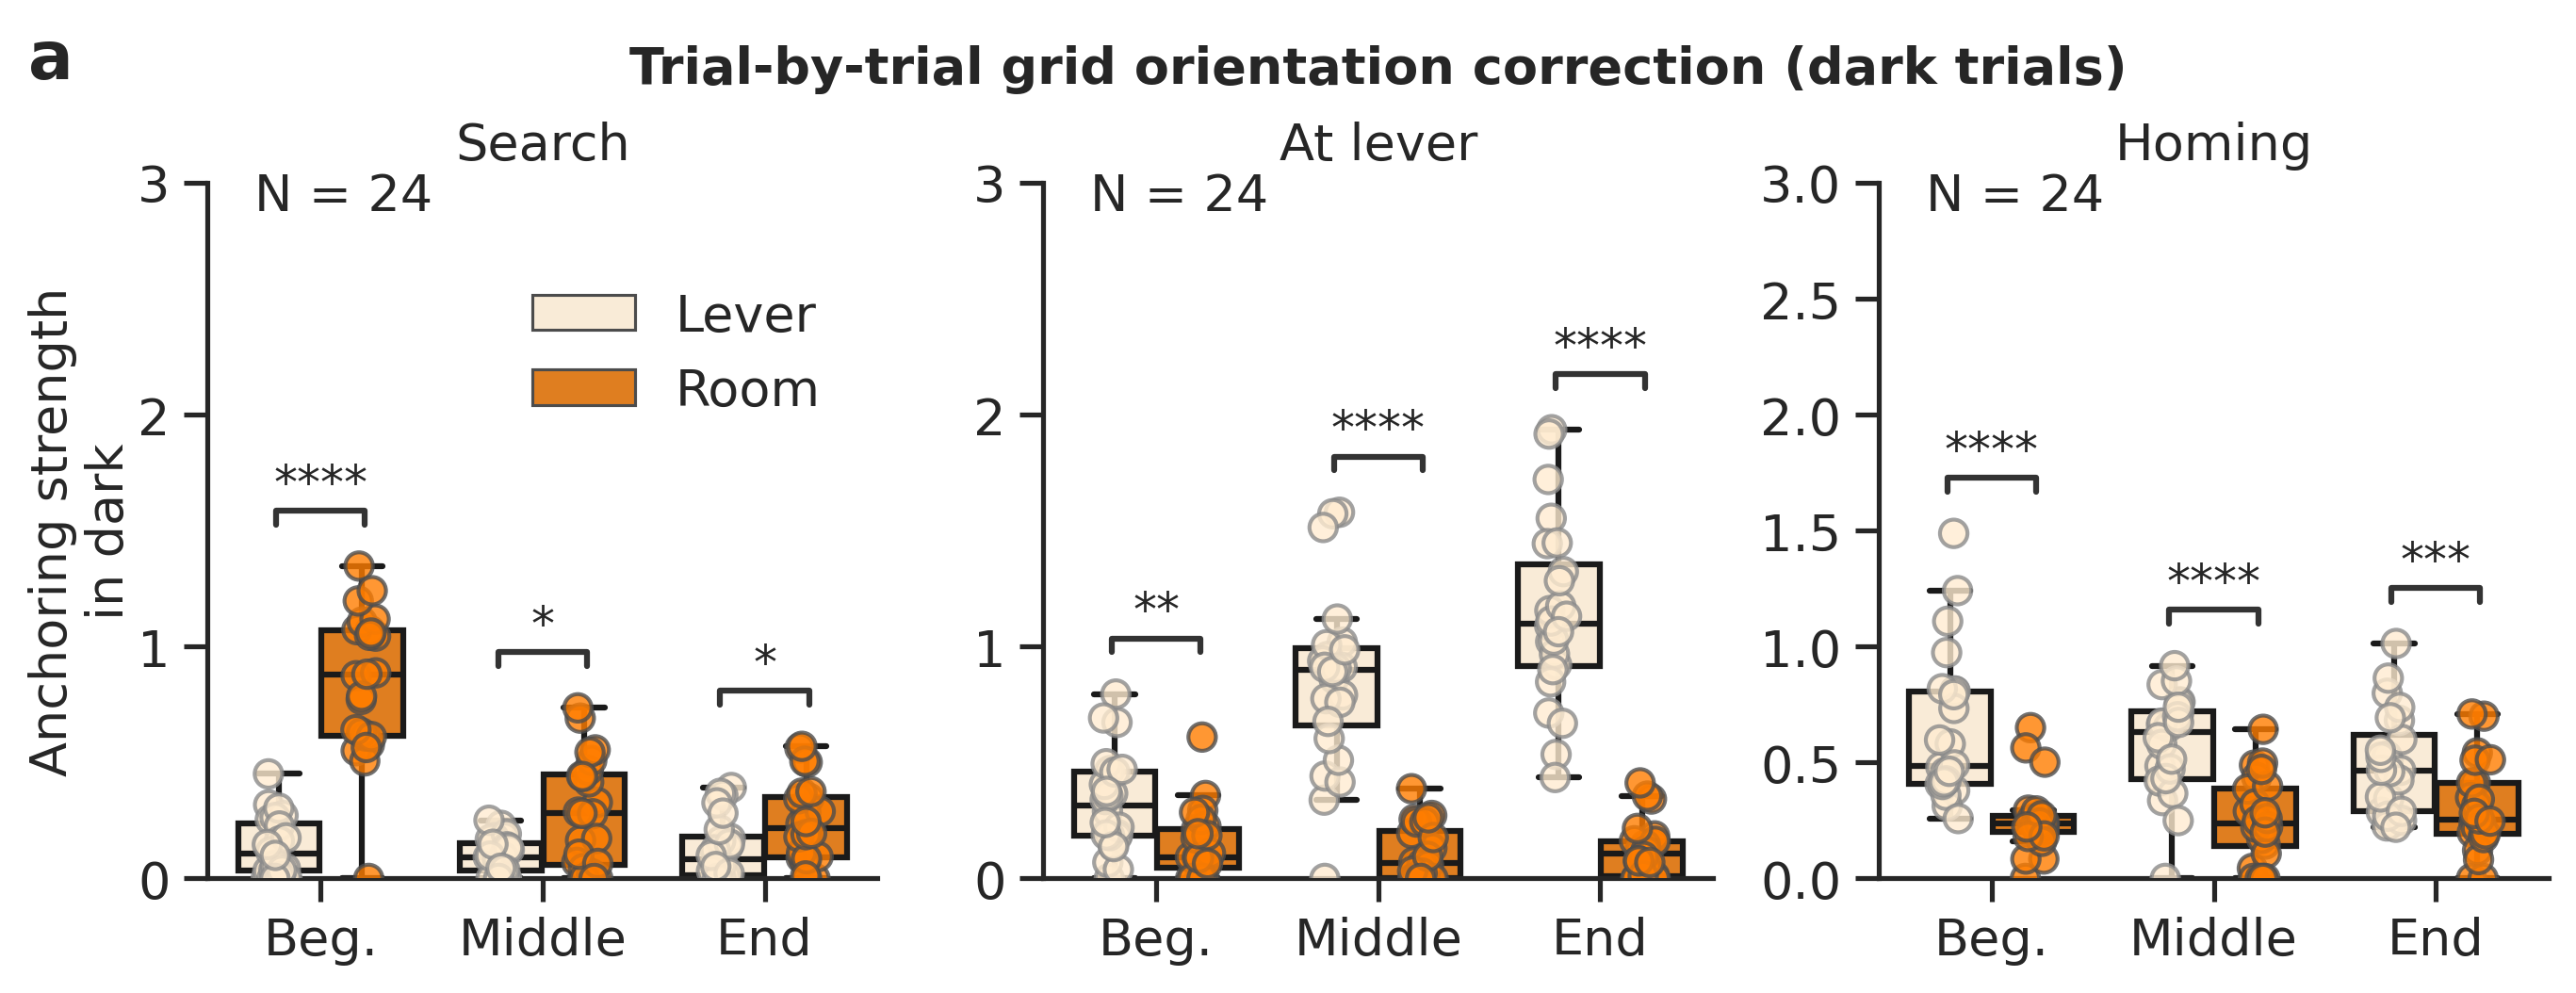

In [30]:
from matplotlib.image import imread
exampleNumber = 3

nrows = 2
ncols = 3
colSize = 3
rowSize = 1.7
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_theme(style = 'ticks')

def add_text(ax,x,y,label,fw = 'normal'):
    ax.text(x,y,label, style='normal', fontweight=fw, fontsize=GLOBALFONTSIZE+4,
                  verticalalignment='center', horizontalalignment='center', transform=ax.transAxes)
    
boxPlotColors = ['#ffecd1','#ff7d00','#15616d','#78290f'] #Lever First,
# #Set the color for this figure

fig = plt.figure(figsize=(ncols*colSize,nrows*rowSize),constrained_layout=True) 
gs = gridspec.GridSpec(nrows, ncols, figure=fig,height_ratios=[0.1,1])

ax0 = fig.add_subplot(gs[0,:])
ax0.text(0.5,0.2, f'Trial-by-trial grid orientation correction (dark trials)',transform=ax0.transAxes,fontsize=GLOBALFONTSIZE,ha='center',fontweight='bold')
ax0.axis('off')


# NOTE Correction type
ax0 = fig.add_subplot(gs[1,0])
condition = 'Search' 
light = 'Dark'
inputDf = all_anchoring_together[(all_anchoring_together.shortCondition==condition)&(all_anchoring_together.light==light)]
plot_anchoring_strength_box(ax0,inputDf, ylabel = 'Anchoring strength\nin dark', title='Search',ylim=3,titleName='Search')
ax0.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE)

ax0 = fig.add_subplot(gs[1,1])
condition = 'Lever' 
inputDf = all_anchoring_together[(all_anchoring_together.shortCondition==condition)&(all_anchoring_together.light==light)]
plot_anchoring_strength_box(ax0,inputDf, title='At lever',legend=False,ylim=3,titleName='At lever')
ax0.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE)

ax0 = fig.add_subplot(gs[1,2])
condition = 'Homing' 
inputDf = all_anchoring_together[(all_anchoring_together.shortCondition==condition)&(all_anchoring_together.light==light)]
plot_anchoring_strength_box(ax0,inputDf, title='Homing',legend=False,ylim=3,titleName='Homing')
ax0.tick_params(axis='both', which='both', labelsize=GLOBALFONTSIZE)


gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[:,:])
#***********************************#
ax0 = fig.add_subplot(gs1[:,:])

#Add figure legend
add_text(ax0,0,1,'a',fw='900')

ax0.axis('off')
###

plt.savefig('../../Output/Sup_Figure8.pdf', bbox_inches='tight', dpi=300)

# Plot grid rotations side by side

In [31]:
def get_grid_rotation_df(myProject):
    """
    Return the dataframe that has the information concerning the rotation of the grid module between the OF and light AutoPI and between OF and dark AutoPI
    """
    fn = myProject.dataPath+"/results/gridRotationDf.csv"
    return pd.read_csv(fn)

def plotGridRotation(ax):
    gridRotationDf = get_grid_rotation_df(myProject)
    
    gridRotationDf = gridRotationDf[gridRotationDf.session.isin(useAble)]
    
    gridRotationDf.light[gridRotationDf.condition=="RF"] = "RF"
    
    gridRotationDf["mouse"] = gridRotationDf.session.str.split("-").str[0]
    gridRotationDf["light_name"] = gridRotationDf["light"].str.capitalize()
    gridRotationDf["light_name"] = gridRotationDf["light_name"].str[0]
    gridRotationDf["light_name"][gridRotationDf["light_name"]=="R"] = "RF2"
    
    
    
    
    b = sns.stripplot(data=gridRotationDf,x="light_name",y="rotation",order=["RF2","L","D"],color=OBSERVATIONCOLOR[0], **stripplot_kwargs) 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel("Grid rotation\n (from RF1)")
    ax.set_xlabel("Task")
    ax.set_ylim(-np.pi/2-0.3,np.pi/2+0.3)
    ax.set_yticks(ticks=[-np.pi/2, 0, np.pi/2])
    ax.set_yticklabels([r'-$\pi/2$', "0", "$\pi/2$"])
    


In [32]:
def plotCorrectedGridRotation(ax,correctedDf):
    
    correctedDf = correctedDf[correctedDf.session.isin(useAble)]
    
    correctedDf.light[correctedDf.condition=="RF"] = "RF"
    correctedDf["mouse"] = correctedDf.session.str.split("-").str[0]
    correctedDf["light_name"] = correctedDf["light"].str.capitalize()
    correctedDf["light_name"] = correctedDf["light_name"].str[0]
    correctedDf["light_name"][correctedDf["light_name"]=="R"] = "RF2"
    
    
    
    
    sns.stripplot(data=correctedDf,x="light_name",y="rotation",order=["RF2","L","D"],color=OBSERVATIONCOLOR[1], **stripplot_kwargs)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel("Aligned grid rotation\n (from RF1)")
    ax.set_xlabel("Task")
    ax.set_ylim(-np.pi/2-0.3,np.pi/2+0.3)
    ax.set_yticks(ticks=[-np.pi/2, 0, np.pi/2])
    ax.set_yticklabels([r'-$\pi/2$', "0", "$\pi/2$"])
    


In [33]:
gridRotationDf = get_grid_rotation_df(myProject)

In [34]:
gridRotationDf

,session,condition,light,rotation,light_name
0,jp1084-05042022-0107,RF,light,-0.153149,Light
1,jp1084-05042022-0107,all_dark,dark,-0.070951,Dark
2,jp1084-05042022-0107,all_light,light,-0.302459,Light
3,jp1084-07042022-0107,RF,light,-0.375449,Light
4,jp1084-07042022-0107,all_dark,dark,-0.459277,Dark
...,...,...,...,...,...
142,mn8578-25122021-0107,all_dark,dark,0.178950,Dark
143,mn8578-25122021-0107,all_light,light,-0.094575,Light
144,mn8599-11022022-0107,RF,light,-0.271788,Light
145,mn8599-11022022-0107,all_dark,dark,-0.162300,Dark


In [35]:
gridRotationDf_not_by_trial = dfMerged[dfMerged.condition.isin(['all_light','all_dark'])].groupby(["session","condition","light"]).apply(meanMvtDirError_wrapper).reset_index()
gridRotationDf_not_by_trial.columns = ["session","condition","light","rotation"]

gridRotationDf_not_by_trial["light_name"] = gridRotationDf_not_by_trial["light"].str.capitalize()
gridRotationDf_not_by_trial["light_name"] = gridRotationDf_not_by_trial["light_name"].str[0]

In [36]:
correctedDf = pd.concat([gridRotationDf_not_by_trial,gridRotationDf[gridRotationDf.condition == 'RF']])

In [37]:
correctedDf

,session,condition,light,rotation,light_name
0,jp1084-05042022-0107,all_dark,dark,-0.126954,D
1,jp1084-05042022-0107,all_light,light,0.036065,L
2,jp1084-07042022-0107,all_dark,dark,-0.000185,D
3,jp1084-07042022-0107,all_light,light,-0.162469,L
4,jp1686-26042022-0108,all_dark,dark,-0.016122,D
...,...,...,...,...,...
132,mn8578-15122021-0107,RF,light,-0.132157,Light
135,mn8578-17122021-0107,RF,light,-0.001619,Light
138,mn8578-23122021-0108,RF,light,0.110114,Light
141,mn8578-25122021-0107,RF,light,0.165844,Light


In [38]:
def add_text(ax, x, y, label, fw="normal"):
    ax.text(
        x,
        y,
        label,
        style="normal",
        fontweight=fw,
        fontsize=GLOBALFONTSIZE + 4,
        verticalalignment="center",
        horizontalalignment="center",
        transform=ax.transAxes,
    )

In [39]:
def calculate_mvl(inputValues):
    # Step 3: Convert to complex numbers
    complex_data = np.exp(1j * inputValues)

    # Step 4: Calculate the mean vector
    mean_vector = np.nanmean(complex_data)

    # Step 5: Calculate the mean vector length
    mean_vector_length = np.abs(mean_vector)
    
    return mean_vector_length

def plot_histplot_after_correction(ax,inputDf,xlabel='Grid rotation\nafter alignment',ylabel='Trials',c='#FF9F1C'):
    b = sns.histplot(data=inputDf,x='rotation',ax=ax,color=c)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(xlabel, fontsize=GLOBALFONTSIZE)
    ax.set_ylabel(ylabel, fontsize=GLOBALFONTSIZE)
    ax.set_xticks(ticks=[-np.pi, 0, np.pi])
    ax.set_xticklabels(["-$\pi$", "0", "$\pi$"], fontsize=GLOBALFONTSIZE)
    ax.set_xlim(-np.pi, np.pi)
    
    mvl = calculate_mvl(inputDf.rotation)
    
    ax.text(0.04, 0.95, f"Dir. precision: {round(mvl,2)}", transform=ax.transAxes,
            ha='left', va='center', fontsize=GLOBALFONTSIZE)
    
    ax.set_ylim(0,150)
    
    totalN = inputDf.shape[0]
    print('Total number:',totalN)
    
    residual_drift = inputDf.abs_rotation.mean()
    residual_std = inputDf.abs_rotation.std()
    print(f"Residual drift: {residual_drift:.2f} +/- {residual_std:.2f}")

In [40]:
fn = myProject.dataPath+"/results/rotation_per_trial_after_correction.csv"
all_dark_trial_df = pd.read_csv(fn)

Total number: 1434
Residual drift: 0.39 +/- 0.41


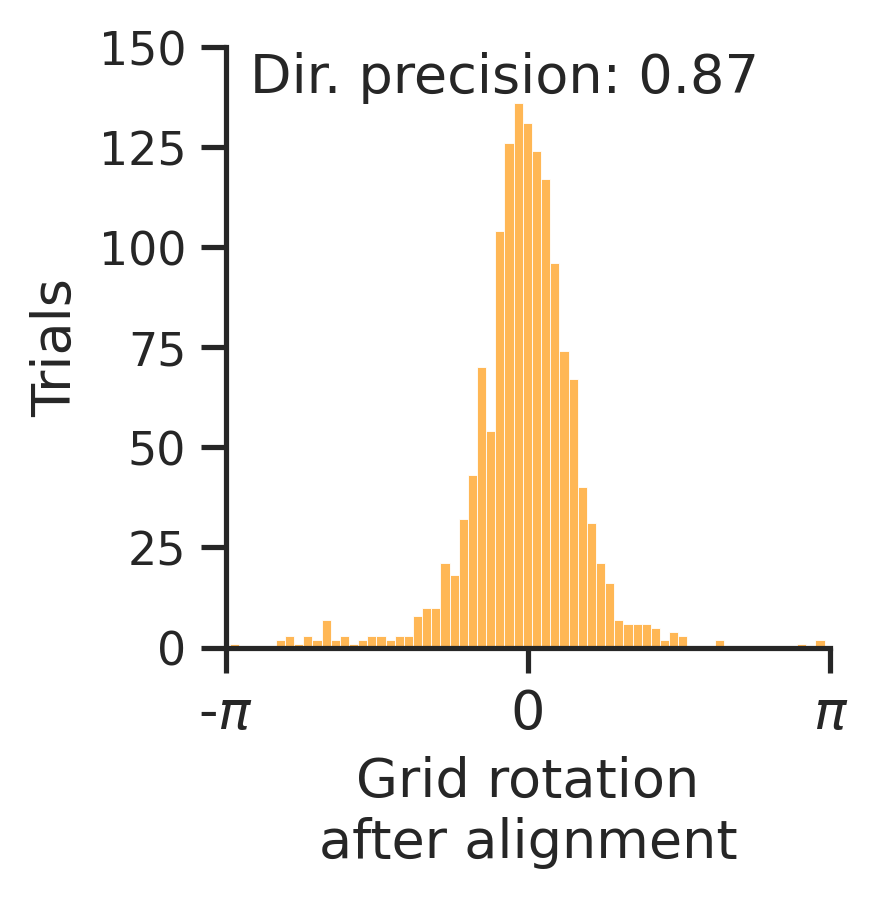

In [41]:
fig, ax =plt.subplots(figsize=(2.6,2.6))
plot_histplot_after_correction(ax,all_dark_trial_df)

In [42]:
stripplot_kwargs = dict({'linewidth': 1, 'size': 3.5, 'alpha': 0.8},)

Total number: 1434
Residual drift: 0.39 +/- 0.41


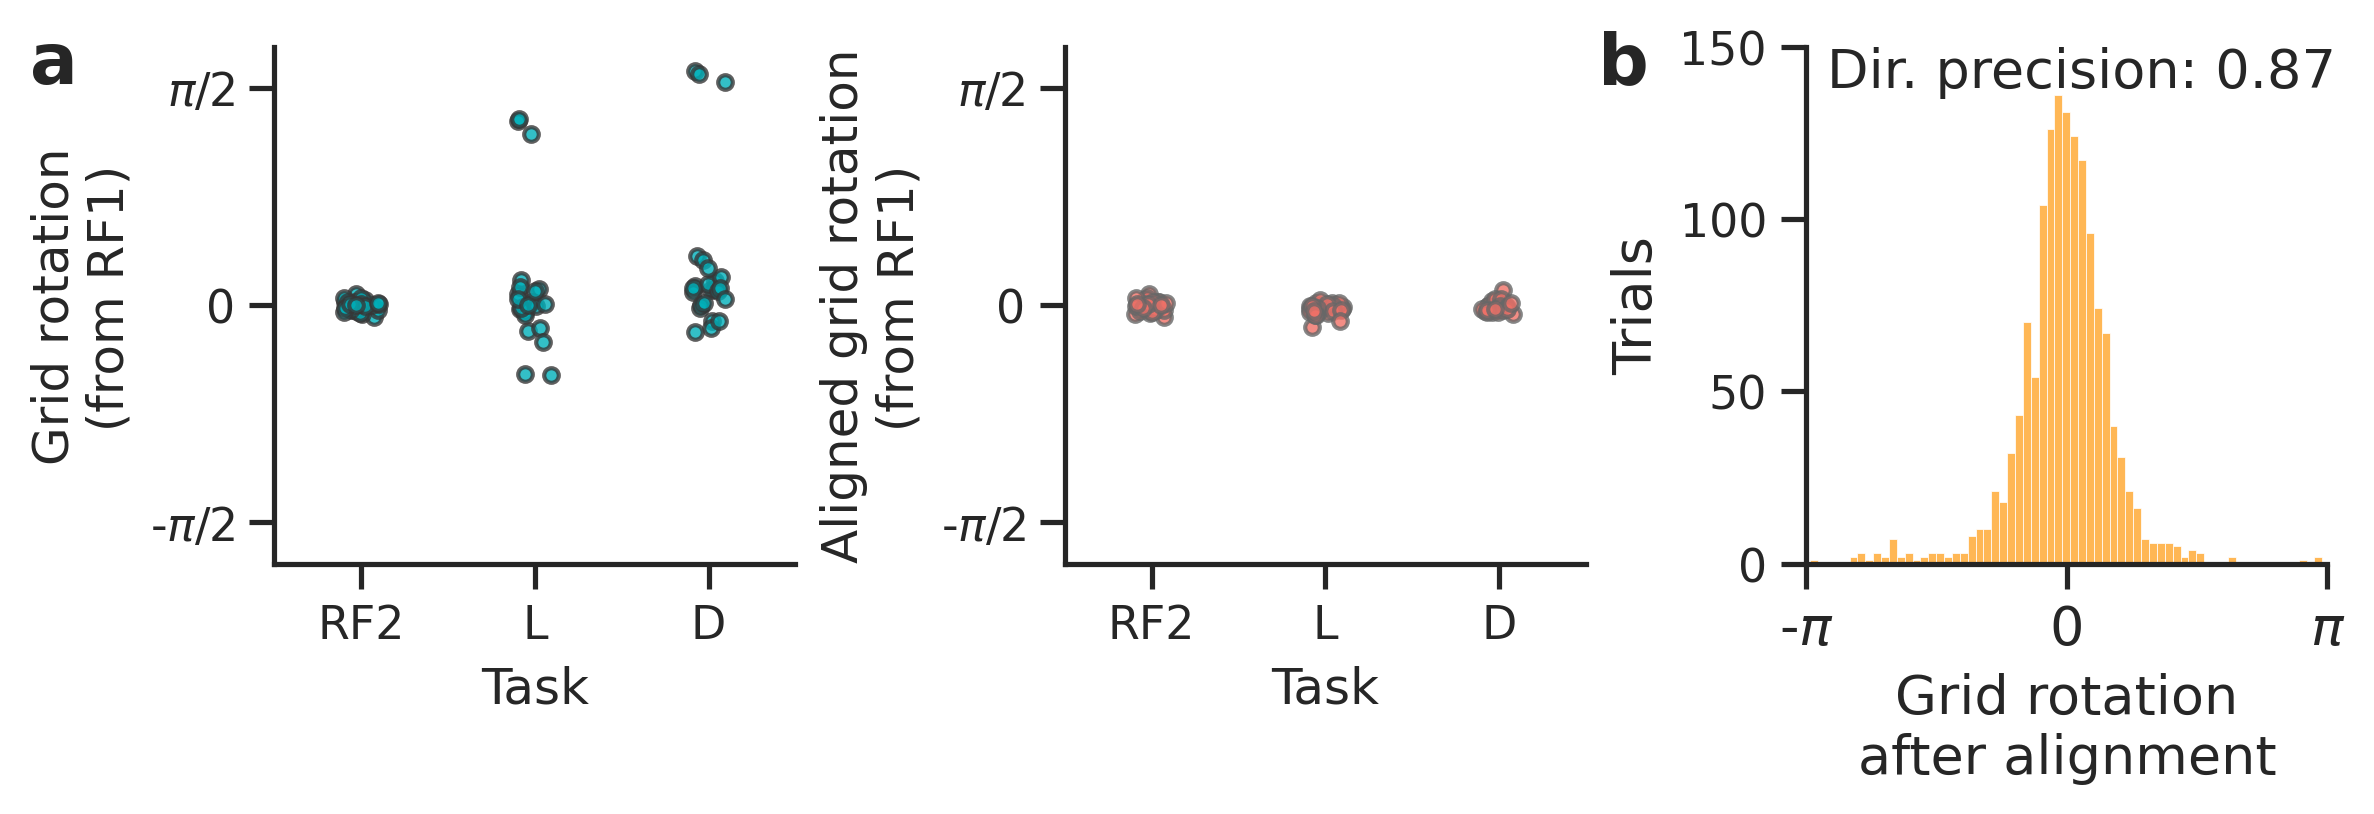

In [43]:
from matplotlib.gridspec import GridSpecFromSubplotSpec

nRows=1
nCols=3
axesRowSize,axesColSize = 2.6,2.6

sns.set(rc={"figure.dpi": 300, 'savefig.dpi': 300})
sns.set_theme(style='ticks')

fig = plt.figure(figsize=(nCols*axesColSize,nRows*axesRowSize), constrained_layout=True) # figsize = (width,height)
gs = fig.add_gridspec(nrows=nRows,ncols=nCols) # create a GridSpec object to a figure

ax0 = fig.add_subplot(gs[0,0])
plotGridRotation(ax0)

ax0 = fig.add_subplot(gs[0,1])
plotCorrectedGridRotation(ax0,correctedDf)


ax0 = fig.add_subplot(gs[0,2])
plot_histplot_after_correction(ax0,all_dark_trial_df)


# NOTE Add figure legends
gs1 = GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[:,:])
#***********************************#
ax0 = fig.add_subplot(gs1[:,:])

#Add figure legend
add_text(ax0,0,1,'a',fw='900')
add_text(ax0,0.685,1,'b',fw='900')

ax0.axis('off')
###

plt.savefig('../../Output/Sup_Figure13.pdf', bbox_inches='tight', dpi=300)